# MLPRegressor

In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde

import kerastuner as kt
import tensorflow as tf


In [33]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-11-06 21:12:45.962030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 21:12:45.962248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 21:12:45.962403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 21:12:45.962598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 21:12:45.962753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Read the etl info results

In [34]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,False,False


## Read the dataset

In [35]:
df = pd.read_csv('../dataset_clean/PlatteRiverWeir_features_v1_clean.csv')
df

,SensorTime,CaptureTime,Stage,Discharge,grayMean,graySigma,entropyMean,entropySigma,hMean,hSigma,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,2.99,916.0,97.405096,39.623303,0.203417,0.979825,105.368375,41.572939,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,2012-06-09 13:15:00,2012-06-09T13:10:29,2.99,916.0,104.066757,40.179745,0.206835,1.002624,112.399458,41.795584,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,2012-06-09 13:45:00,2012-06-09T13:44:01,2.96,873.0,105.636831,40.533218,0.204756,0.994246,114.021526,42.145582,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,2012-06-09 14:45:00,2012-06-09T14:44:30,2.94,846.0,104.418949,41.752678,0.202428,0.983170,112.612830,43.575351,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,2012-06-09 15:45:00,2012-06-09T15:44:59,2.94,846.0,106.763541,44.442097,0.202661,0.989625,114.839424,46.302008,...,-1,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,2.54,434.0,82.872720,57.702652,0.221708,1.076393,87.260572,61.485334,...,2446,1900,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,2.54,434.0,89.028383,55.840861,0.233168,1.124774,94.175906,59.006132,...,2440,1900,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,2.54,434.0,94.722097,54.355753,0.240722,1.151833,100.534577,56.921028,...,2447,1900,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,2.54,434.0,96.693270,52.787629,0.244789,1.171987,102.891159,55.083532,...,2443,1900,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896


In [36]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year

In [37]:
df.dtypes

SensorTime          datetime64[ns]
CaptureTime                 object
Stage                      float64
Discharge                  float64
grayMean                   float64
graySigma                  float64
entropyMean                float64
entropySigma               float64
hMean                      float64
hSigma                     float64
sMean                      float64
sSigma                     float64
vMean                      float64
vSigma                     float64
areaFeatCount                int64
grayMean0                  float64
graySigma0                 float64
entropyMean0               float64
entropySigma0              float64
hMean0                     float64
hSigma0                    float64
sMean0                     float64
sSigma0                    float64
vMean0                     float64
vSigma0                    float64
grayMean1                  float64
graySigma1                 float64
entropyMean1               float64
entropySigma1       

## Divide dataset to X and Y

In [38]:
df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [39]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [40]:
np.random.seed(0)

y_train = df_train[["Stage", "Discharge"]]
X_train = df_train.drop(columns=["Stage", "Discharge"])

temp = list(zip(X_train.values, y_train.values))
np.random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train, y_train = np.array(X_train), np.array(y_train)

y_test = df_test[["Stage", "Discharge"]]
X_test = df_test.drop(columns=["Stage", "Discharge"])

temp = list(zip(X_test.values, y_test.values))
np.random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test, y_test = np.array(X_test), np.array(y_test)

In [41]:
print(X_train.shape)
print(y_train.shape)

(28811, 44)
(28811, 2)


In [42]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

## Train model

In [46]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=input_shape))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 128, max_value = 1024, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
  hp_units_2 = hp.Int('units_2', min_value = 128, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation = 'relu'))
  hp_units_3 = hp.Int('units_3', min_value = 64, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation = 'relu'))
  hp_units_4 = hp.Int('units_4', min_value = 64, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_4, activation = 'relu'))
  """
  hp_units_5 = hp.Int('units_5', min_value = 128, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_5, activation = 'relu'))
  hp_units_6 = hp.Int('units_6', min_value = 64, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_6, activation = 'relu'))
  hp_units_7 = hp.Int('units_7', min_value = 64, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_7, activation = 'relu'))
  hp_units_8 = hp.Int('units_8', min_value = 32, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_8, activation = 'relu'))"""

  model.add(tf.keras.layers.Dense(output_shape))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss = 'mse', metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])
  
  return model

In [47]:
tuner = kt.RandomSearch(model_builder,
                        objective = 'val_loss', 
                        max_trials = 10,
                        #directory = 'random_search_starter',
                        project_name = 'MLPtf') 

In [48]:
tuner.search(X_train, y_train, epochs = 40, validation_data = (X_test, y_test))

Trial 10 Complete [00h 01m 18s]
val_loss: 109976.1796875

Best val_loss So Far: 104425.8203125
Total elapsed time: 00h 13m 04s
INFO:tensorflow:Oracle triggered exit


In [49]:
best_model = tuner.get_best_models(1)[0]

In [50]:

best_hyperparameters = tuner.get_best_hyperparameters(1)[0] 

## Test model

In [51]:
best_model.evaluate(X_test, y_test)


414/414 [==============================] - 1s 1ms/step - loss: 104425.8203 - mse: 104425.8203 - rmse: 323.1498 - mae: 144.4191 - mape: 5165232640.0000


[104425.8203125,
 104425.8203125,
 323.14984130859375,
 144.4191131591797,
 5165232640.0]

In [52]:
y_pred = best_model.predict(X_test)

414/414 [==============================] - 0s 601us/step


In [53]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  -1.5115277087651755
mse:  104425.83337379005
rmse:  229.17087825115055
mae:  144.41915749977616
mape:  2.3262143641528052e+16
Error estandar:  [  1.21269654 431.11023937]


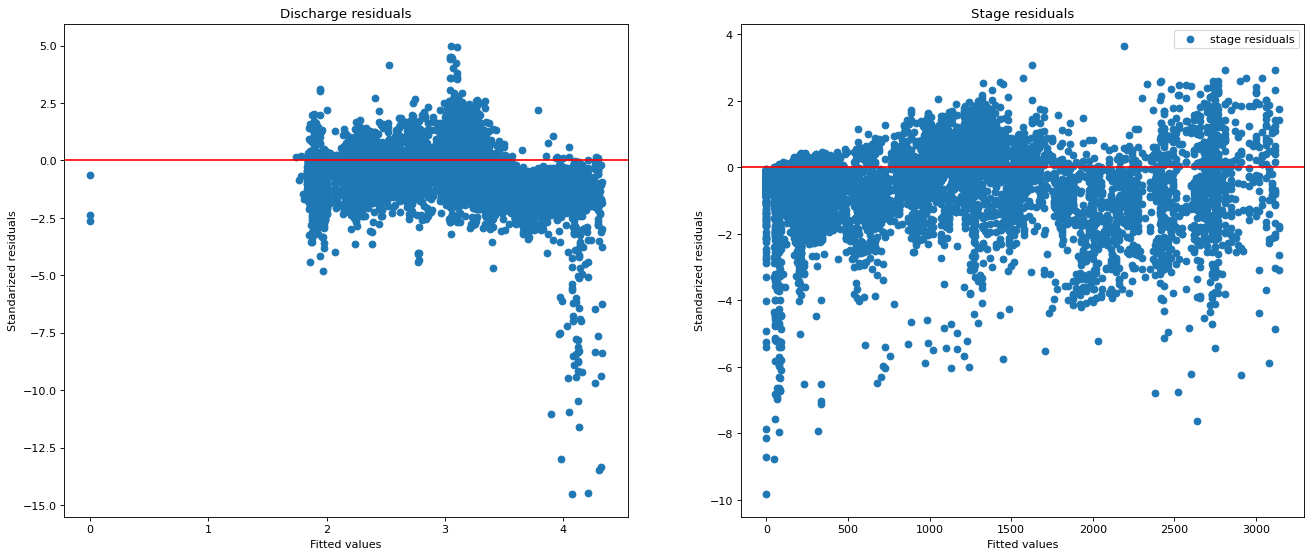

In [57]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[-1] for i in y_test])
residual_stage = np.array([i[-1] for i in residuals])

y_real_discharge = np.array([i[0] for i in y_test])
residual_discharge = np.array([i[0] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

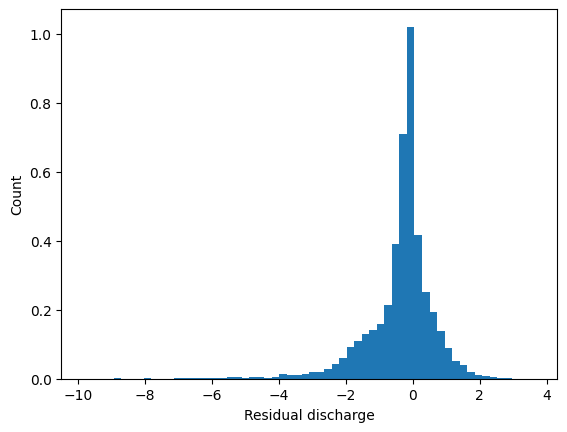

In [58]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

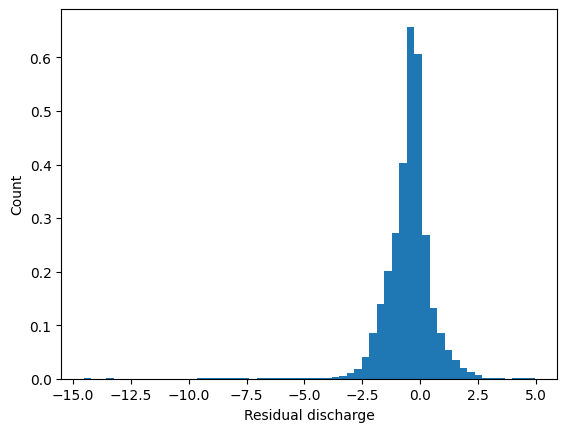

In [59]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()